<ipython-input-1-06d4c2bb03b3>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
<ipython-input-1-06d4c2bb03b3>:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_balance = user_balance.groupby(['report_date'])['share_amt', 'total_purchase_amt'].sum()
<ipython-input-1-06d4c2bb03b3>:125: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 1 fit loss: 0.17458461 valid loss: 0.13438272
epoch: 2 fit loss: 0.063646294 valid loss: 0.026913527
epoch: 3 fit loss: 0.054695085 valid loss: 0.0248337
epoch: 4 fit loss: 0.046958283 valid loss: 0.022783345
epoch: 5 fit loss: 0.04261311 valid 

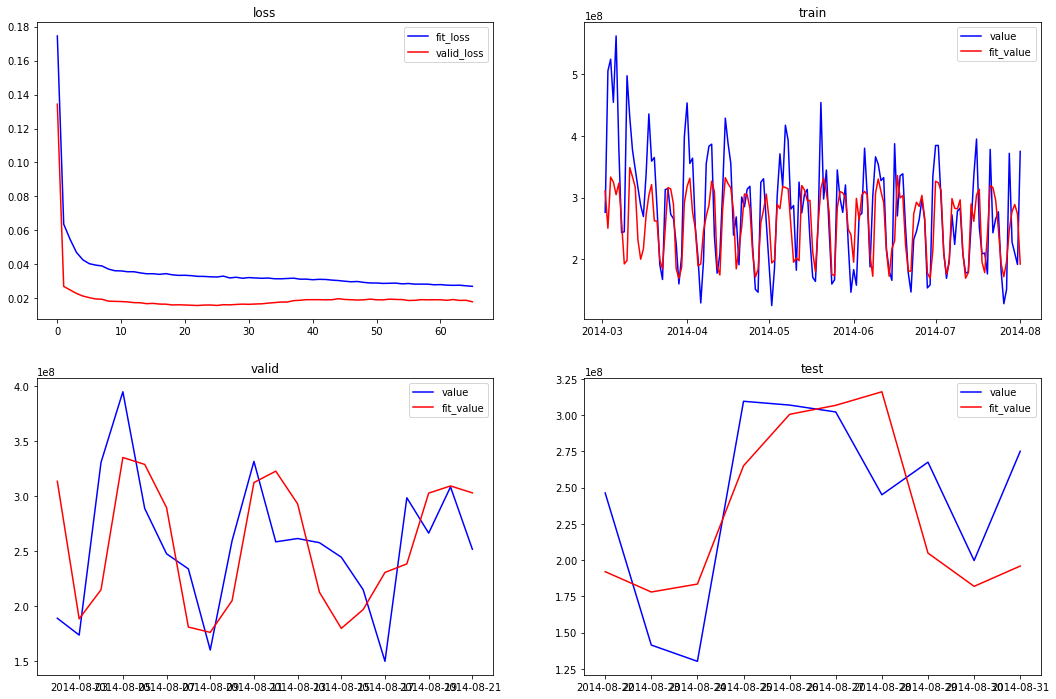

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import tensorflow
tf = tensorflow.compat.v1
# 关闭动态图执行
tf.disable_eager_execution()

tf.reset_default_graph()

def generate_data():
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
    user_balance = pd.read_csv('user_balance_table.csv', parse_dates=['report_date'], date_parser=dateparse)

    user_balance = user_balance.groupby(['report_date'])['share_amt', 'total_purchase_amt'].sum()
    user_balance.reset_index(inplace=True)
    user_balance.index = user_balance['report_date']

    user_balance = user_balance['2014-03-01':'2014-08-31']

    data = {'total_purchase_amt': user_balance['total_purchase_amt']}

    df = pd.DataFrame(data=data, index=user_balance.index)
    df.to_csv(path_or_buf='single_purchase_seq.csv')


# 数据集归一化
def get_normal_data(purchase_seq):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(purchase_seq[['total_purchase_amt']])
    scaled_x_data = scaled_data[0: -1]
    scaled_y_data = scaled_data[1:]
    return scaled_x_data, scaled_y_data, scaler


# 构造训练集
def get_train_data(scaled_x_data, scaled_y_data, divide_train_valid_index, time_step):
    train_x, train_y = [], []
    normalized_train_feature = scaled_x_data[0: -divide_train_valid_index]
    normalized_train_label = scaled_y_data[0: -divide_train_valid_index]
    for i in range(len(normalized_train_feature) - time_step + 1):
        train_x.append(normalized_train_feature[i:i + time_step].tolist())
        train_y.append(normalized_train_label[i:i + time_step].tolist())
    return train_x, train_y


# 构造拟合训练集
def get_train_fit_data(scaled_x_data, scaled_y_data, divide_train_valid_index, time_step):
    train_fit_x, train_fit_y = [], []
    normalized_train_feature = scaled_x_data[0: -divide_train_valid_index]
    normalized_train_label = scaled_y_data[0: -divide_train_valid_index]
    train_fit_remain = len(normalized_train_label) % time_step
    train_fit_num = int((len(normalized_train_label) - train_fit_remain) / time_step)
    temp = []
    for i in range(train_fit_num):
        train_fit_x.append(normalized_train_feature[i * time_step:(i + 1) * time_step].tolist())
        temp.extend(normalized_train_label[i * time_step:(i + 1) * time_step].tolist())
    if train_fit_remain > 0:
        train_fit_x.append(normalized_train_feature[-time_step:].tolist())
        temp.extend(normalized_train_label[-train_fit_remain:].tolist())
    for i in temp:
        train_fit_y.append(i[0])
    return train_fit_x, train_fit_y, train_fit_remain


# 构造验证集
def get_valid_data(scaled_x_data, scaled_y_data, divide_train_valid_index, divide_valid_test_index, time_step):
    valid_x, valid_y = [], []
    normalized_valid_feature = scaled_x_data[-divide_train_valid_index: -divide_valid_test_index]
    normalized_valid_label = scaled_y_data[-divide_train_valid_index: -divide_valid_test_index]
    valid_remain = len(normalized_valid_label) % time_step
    valid_num = int((len(normalized_valid_label) - valid_remain) / time_step)
    temp = []
    for i in range(valid_num):
        valid_x.append(normalized_valid_feature[i * time_step:(i + 1) * time_step].tolist())
        temp.extend(normalized_valid_label[i * time_step:(i + 1) * time_step].tolist())
    if valid_remain > 0:
        valid_x.append(normalized_valid_feature[-time_step:].tolist())
        temp.extend(normalized_valid_label[-valid_remain:].tolist())
    for i in temp:
        valid_y.append(i[0])
    return valid_x, valid_y, valid_remain


# 构造测试集
def get_test_data(scaled_x_data, scaled_y_data, divide_valid_test_index, time_step):
    test_x, test_y = [], []
    normalized_test_feature = scaled_x_data[-divide_valid_test_index:]
    normalized_test_label = scaled_y_data[-divide_valid_test_index:]
    test_remain = len(normalized_test_label) % time_step
    test_num = int((len(normalized_test_label) - test_remain) / time_step)
    temp = []
    for i in range(test_num):
        test_x.append(normalized_test_feature[i * time_step:(i + 1) * time_step].tolist())
        temp.extend(normalized_test_label[i * time_step:(i + 1) * time_step].tolist())
    if test_remain > 0:
        test_x.append(scaled_x_data[-time_step:].tolist())
        temp.extend(normalized_test_label[-test_remain:].tolist())
    for i in temp:
        test_y.append(i[0])
    return test_x, test_y, test_remain

generate_data()


# 模型参数
lr = 1e-3  # 学习率
batch_size = 10  # minibatch 大小
rnn_unit = 30  # LSTM 隐藏层神经元数量
input_size = 1  # 单元的输入数量
output_size = 1  # 单元的输出数量
time_step = 15  # 时间长度
epochs = 1000  # 训练次数
gradient_threshold = 15  # 梯度裁剪阈值
stop_loss = np.float32(0.045)  # 训练停止条件。当训练误差 + 验证误差小于阈值时，停止训练
train_keep_prob = [1.0, 0.5, 1.0]  # 训练时 dropout 神经元保留比率

# 数据切分参数
divide_train_valid_index = 30
divide_valid_test_index = 10

# 数据准备
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
single_purchase_seq = pd.read_csv('single_purchase_seq.csv', parse_dates=['report_date'], index_col='report_date', date_parser=dateparse)

scaled_x_data, scaled_y_data, scaler = get_normal_data(single_purchase_seq)
train_x, train_y = get_train_data(scaled_x_data, scaled_y_data, divide_train_valid_index, time_step)
train_fit_x, train_fit_y, train_fit_remain = get_train_fit_data(scaled_x_data, scaled_y_data, divide_train_valid_index, time_step)
valid_x, valid_y, valid_remain = get_valid_data(scaled_x_data, scaled_y_data, divide_train_valid_index, divide_valid_test_index, time_step)
test_x, test_y, test_remain = get_test_data(scaled_x_data, scaled_y_data, divide_valid_test_index, time_step)


def lstm(X, keep_prob):
    batch_size = tf.shape(X)[0]  # minibatch 大小

    # 输入到 LSTM 输入的转换，一层全连接的网络，其中权重初始化采用截断的高斯分布，激活函数采用tanh
    weights = tf.Variable(tf.truncated_normal(shape=[input_size, rnn_unit]))
    biases = tf.Variable(tf.constant(0.1, shape=[rnn_unit, ]))
    input = tf.reshape(X, [-1, input_size])

    tanh_layer = tf.nn.tanh(tf.matmul(input, weights) + biases)
    input_rnn = tf.nn.dropout(tanh_layer, keep_prob[0])
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])

    # 两层 LSTM 网络，激活函数默认采用 tanh，当网络层数较深时，建议使用 relu
    initializer = tf.truncated_normal_initializer()
    cell_1 = tf.nn.rnn_cell.LSTMCell(forget_bias=1.0, num_units=rnn_unit, use_peepholes=True, num_proj=None, initializer=initializer, name='lstm_cell_1')
    cell_1_drop = tf.nn.rnn_cell.DropoutWrapper(cell=cell_1, output_keep_prob=keep_prob[1])

    cell_2 = tf.nn.rnn_cell.LSTMCell(forget_bias=1.0, num_units=rnn_unit, use_peepholes=True, num_proj=output_size, initializer=initializer, name='lstm_cell_2')
    cell_2_drop = tf.nn.rnn_cell.DropoutWrapper(cell=cell_2, output_keep_prob=keep_prob[2])

    mutilstm_cell = tf.nn.rnn_cell.MultiRNNCell(cells=[cell_1_drop, cell_2_drop], state_is_tuple=True)
    init_state = mutilstm_cell.zero_state(batch_size, dtype=tf.float32)

    with tf.variable_scope('lstm', reuse=tf.AUTO_REUSE):
        output, state = tf.nn.dynamic_rnn(cell=mutilstm_cell, inputs=input_rnn, initial_state=init_state, dtype=tf.float32)

    return output, state

# 获取拟合数据，这里用于拟合，关闭 dropout
def get_fit_seq(x, remain, sess, output, X, keep_prob, scaler, inverse):
    fit_seq = []
    if inverse:
        # 前面对数据进行了归一化，这里反归一化还原数据
        temp = []
        for i in range(len(x)):
            next_seq = sess.run(output, feed_dict={X: [x[i]], keep_prob: [1.0, 1.0, 1.0]})
            if i == len(x) - 1:
                temp.extend(scaler.inverse_transform(next_seq[0].reshape(-1, 1))[-remain:])
            else:
                temp.extend(scaler.inverse_transform(next_seq[0].reshape(-1, 1)))
        for i in temp:
            fit_seq.append(i[0])
    else:
        for i in range(len(x)):
            next_seq = sess.run(output,
                                feed_dict={X: [x[i]], keep_prob: [1.0, 1.0, 1.0]})
            if i == len(x) - 1:
                fit_seq.extend(next_seq[0].reshape(1, -1).tolist()[0][-remain:])
            else:
                fit_seq.extend(next_seq[0].reshape(1, -1).tolist()[0])

    return fit_seq


def train_lstm():
    X = tf.placeholder(tf.float32, [None, time_step, input_size])
    Y = tf.placeholder(tf.float32, [None, time_step, output_size])

    keep_prob = tf.placeholder(tf.float32, [None])
    output, state = lstm(X, keep_prob)
    loss = tf.losses.mean_squared_error(tf.reshape(output, [-1]), tf.reshape(Y, [-1]))

    # 梯度优化与裁剪
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    grads, variables = zip(*optimizer.compute_gradients(loss))
    grads, global_norm = tf.clip_by_global_norm(grads, gradient_threshold)
    train_op = optimizer.apply_gradients(zip(grads, variables))

    X_train_fit = tf.placeholder(tf.float32, [None])
    Y_train_fit = tf.placeholder(tf.float32, [None])
    train_fit_loss = tf.losses.mean_squared_error(tf.reshape(X_train_fit, [-1]), tf.reshape(Y_train_fit, [-1]))

    X_valid = tf.placeholder(tf.float32, [None])
    Y_valid = tf.placeholder(tf.float32, [None])
    valid_fit_loss = tf.losses.mean_squared_error(tf.reshape(X_valid, [-1]), tf.reshape(Y_valid, [-1]))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        fit_loss_seq = []
        valid_loss_seq = []

        for epoch in range(epochs):
            for index in range(len(train_x) - batch_size + 1):
               sess.run(train_op, feed_dict={X: train_x[index: index + batch_size], Y: train_y[index: index + batch_size], keep_prob: train_keep_prob})

            # 拟合训练集和验证集
            train_fit_seq = get_fit_seq(train_fit_x, train_fit_remain, sess, output, X, keep_prob, scaler, False)
            train_loss = sess.run(train_fit_loss, {X_train_fit: train_fit_seq, Y_train_fit: train_fit_y})
            fit_loss_seq.append(train_loss)

            valid_seq = get_fit_seq(valid_x, valid_remain, sess, output, X, keep_prob, scaler, False)
            valid_loss = sess.run(valid_fit_loss, {X_valid: valid_seq, Y_valid: valid_y})
            valid_loss_seq.append(valid_loss)

            print('epoch:', epoch + 1, 'fit loss:', train_loss, 'valid loss:', valid_loss)

            # 提前终止条件。
            # 常见的方法是验证集达到最小值，再往后训练 n 步，loss 不再减小，实际测试这里使用的效果不好。
            # 这里选择 stop_loss 是经过多次尝试得到的阈值。
            if train_loss + valid_loss <= stop_loss:
                train_fit_seq = get_fit_seq(train_fit_x, train_fit_remain, sess, output, X, keep_prob, scaler, True)
                valid_fit_seq = get_fit_seq(valid_x, valid_remain, sess, output, X, keep_prob, scaler, True)
                test_fit_seq = get_fit_seq(test_x, test_remain, sess, output, X, keep_prob, scaler, True)
                print('best epoch: ', epoch + 1)
                break


    return fit_loss_seq, valid_loss_seq, train_fit_seq, valid_fit_seq, test_fit_seq


fit_loss_seq, valid_loss_seq, train_fit_seq, valid_fit_seq, test_fit_seq = train_lstm()

# 切分训练集、测试集
purchase_seq_train = single_purchase_seq[1:-divide_train_valid_index]
purchase_seq_valid = single_purchase_seq[-divide_train_valid_index:-divide_valid_test_index]
purchase_seq_test = single_purchase_seq[-divide_valid_test_index:]

plt.figure(figsize=(18, 12))

plt.subplot(221)
plt.title('loss')
plt.plot(fit_loss_seq, label='fit_loss', color='blue')
plt.plot(valid_loss_seq, label='valid_loss', color='red')
plt.legend(loc='best')

plt.subplot(222)
plt.title('train')
seq_train_fit = pd.DataFrame(columns=['total_purchase_amt'], data=train_fit_seq, index=purchase_seq_train.index)
plt.plot(purchase_seq_train['total_purchase_amt'], label='value', color='blue')
plt.plot(seq_train_fit['total_purchase_amt'], label='fit_value', color='red')
plt.legend(loc='best')

plt.subplot(223)
plt.title('valid')
seq_valid_fit = pd.DataFrame(columns=['total_purchase_amt'], data=valid_fit_seq, index=purchase_seq_valid.index)
plt.plot(purchase_seq_valid['total_purchase_amt'], label='value', color='blue')
plt.plot(seq_valid_fit['total_purchase_amt'], label='fit_value', color='red')
plt.legend(loc='best')

plt.subplot(224)
plt.title('test')
seq_test_fit = pd.DataFrame(columns=['total_purchase_amt'], data=test_fit_seq, index=purchase_seq_test.index)
plt.plot(purchase_seq_test['total_purchase_amt'], label='value', color='blue')
plt.plot(seq_test_fit['total_purchase_amt'], label='fit_value', color='red')
plt.legend(loc='best')

plt.show()
